### Installing Yolo package

In [ ]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.5 MB/s eta 0:00:00


### Creating Training Dataset

In [ ]:
import cv2
import numpy as np
from tqdm import tqdm
from pathlib import Path
from ultralytics import YOLO
from collections import deque

# -- Configuration ---
MODEL_PATH = "best_patrick_cp_1000.pt"
VIDEO_PATH = "warriors.mp4"
FIXED_FPS  = 30
CLIP_LEN   = 15
PAD_PIXELS = 20
FIXED_HW   = (128, 128)
ACTION_CLS = ["NONE", "SHOOT", "LAYUP", "DUNK"]

class ActionClassifier:
    def __init__(self):
        self.yolo = YOLO(MODEL_PATH)
        self.cap = cv2.VideoCapture(VIDEO_PATH)

        if not self.cap.isOpened():
            raise RuntimeError(f"Unable to open video: {VIDEO_PATH}")

        self.fps_ratio   = max(1, round(self.cap.get(cv2.CAP_PROP_FPS)) // FIXED_FPS)
        self.frame_count = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Buffers for raw frames and detection status
        self.raw_buffer = deque(maxlen=CLIP_LEN)
        self.detect_buffer = deque(maxlen=CLIP_LEN)


    def __del__(self):
        if self.cap.isOpened():
            self.cap.release()
        

    def detect_lebron(self, frame):
        result = self.yolo.predict(frame, imgsz=1280, conf=0.43, max_det=1, verbose=False)[0]
        if not result.boxes:
            return None

        x1, y1, x2, y2 = result.boxes.xyxy[0].cpu().numpy().astype(int)
        h, w, _ = frame.shape

        # Apply padding
        x1 = max(0, x1 - PAD_PIXELS)
        y1 = max(0, y1 - PAD_PIXELS)
        x2 = min(w, x2 + PAD_PIXELS)
        y2 = min(h, y2 + PAD_PIXELS)
        return x1, y1, x2, y2


    def write_frames(self, frames, id, labels, out_dir):
        t = id // FIXED_FPS

        for i in range(1, len(ACTION_CLS)):
            if t in labels[i]:
                path = out_dir / f"class_{i}" / f"{id}.npy"
                np.save(path, frames)
                return
        
        # Save as 'NONE' if no action class matches
        path = out_dir / "class_0" / f"{id}.npy"
        np.save(path, frames)


    def make_dataset(self, labels, out_dir, save=False):
        for id in tqdm(range(0, self.frame_count, self.fps_ratio)):
            
            for _ in range(self.fps_ratio):
                ret, frame = self.cap.read()
                if not ret:
                    raise RuntimeError(f"Unable to read frame: {id}")

            box = self.detect_lebron(frame)
            self.detect_buffer.append(box is not None)

            if box:
                x1, y1, x2, y2 = box
                crop = frame[y1:y2, x1:x2]
                crop = cv2.resize(crop, FIXED_HW)
                self.raw_buffer.append(crop)
            
            # Duplicate the last valid frame if not detected
            elif len(self.raw_buffer):
                self.raw_buffer.append(self.raw_buffer[-1].copy())

            if len(self.raw_buffer) == CLIP_LEN and any(self.detect_buffer):
                if save:
                    frames = np.stack(list(self.raw_buffer)[::2], axis=0)
                    self.write_frames(frames, id, labels, out_dir)
                else:
                    cv2.imshow(f"Frame ID: {id}", self.raw_buffer[-1])
            
            # Clear the buffer if no detection for a while
            elif not any(self.detect_buffer):
                self.raw_buffer.clear()

In [ ]:
# Unlabeled frames are classified as NONE
LABELS = {
    1: [27, 32.5, 66.5, 206, 315.5, 320.5, 408, 607.5, 626.5, 628, 678, 684.5, 697.5, 771],
    2: [347.5, 397, 593.5, 766],
    3: [123]
}

# Convert time-based labels (in seconds) to frame indices (at 30 FPS)
for k, v in LABELS.items():
    LABELS[k] = [int(t * 2) + offset for t in v for offset in range(2)]

print(LABELS)

{1: [54, 55, 65, 66, 133, 134, 412, 413, 631, 632, 641, 642, 816, 817, 1215, 1216, 1253, 1254, 1256, 1257, 1356, 1357, 1369, 1370, 1395, 1396, 1542, 1543], 2: [695, 696, 794, 795, 1187, 1188, 1532, 1533], 3: [246, 247]}


In [ ]:
OUT_DIR = Path("/lebron_clips")

# Create output directories for each action class
for i in range(len(ACTION_CLS)):
    path = OUT_DIR / f"class_{i}"
    path.mkdir(parents=True, exist_ok=True)

# Main execution
classifier = ActionClassifier()
classifier.make_dataset(LABELS, OUT_DIR, save=True)

100%|██████████| 11923/11923 [6:32:56<00:00,  1.98s/it]


### Training Action Classifier

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, random_split

# Set global seed for reproducibility
torch.manual_seed(0)

# Find available device
device = "cuda" if torch.cuda.is_available() else "cpu"

class ShotBinaryDataset(Dataset):
    def __init__(self, root_dir):
        self.samples = []
        for i in range(len(ACTION_CLS)):
            dir = root_dir / f'class_{i}'
            for path in dir.glob('*.npy'):
                self.samples.append((str(path), i))

        self.transform = T.Compose([
            T.ToPILImage(),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        frames = np.load(path)
        clip = torch.stack([self.transform(frame) for frame in frames], dim=1)
        return clip, torch.tensor(label, dtype=torch.long)

In [ ]:
# Load the dataset
dataset_dir = Path("/lebron_clips")
ds = ShotBinaryDataset(dataset_dir)

# 80-20 split
train_size = int(0.8 * len(ds))
val_size = len(ds) - train_size
train_ds, val_ds = random_split(ds, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2)

In [ ]:
def model_trainer(train_loader, val_loader, device, epochs=5, lr=1e-4, criterion=None):
    # Load pretrained 3D ResNet-18 model and modify final layer for 4 classes
    model = torchvision.models.video.r3d_18(weights="DEFAULT")
    model.fc = nn.Linear(model.fc.in_features, 4)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = criterion or nn.CrossEntropyLoss()

    hist = {
        "train_loss": [],
        "train_acc" : [],
        "val_loss"  : [],
        "val_acc"   : [],
    }

    for epoch in range(1, epochs+1):
        print(f"Epoch {epoch}:")
    
        # Training phase
        model.train()
        train_loss = 0
        train_acc = 0
        for clips, labels in tqdm(train_loader):
            clips = clips.to(device)
            labels = labels.to(device)

            logits = model(clips)
            loss = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = logits.argmax(1)
            train_acc += (preds == labels).float().mean().item()

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        hist["train_loss"].append(train_loss)
        hist["train_acc"].append(train_acc)

        # Validation phase
        model.eval()
        val_loss = 0
        val_acc = 0
        with torch.no_grad():
            for clips, labels in val_loader:
                clips = clips.to(device)
                labels = labels.to(device)

                logits = model(clips)
                loss = criterion(logits, labels)

                val_loss += loss.item()
                preds = logits.argmax(1)
                val_acc += (preds == labels).float().mean().item()

        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        hist["val_loss"].append(val_loss)
        hist["val_acc"].append(val_acc)

        print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}, val_loss: {val_loss:.3f}, val_acc: {val_acc:.3f}")

    return model, hist

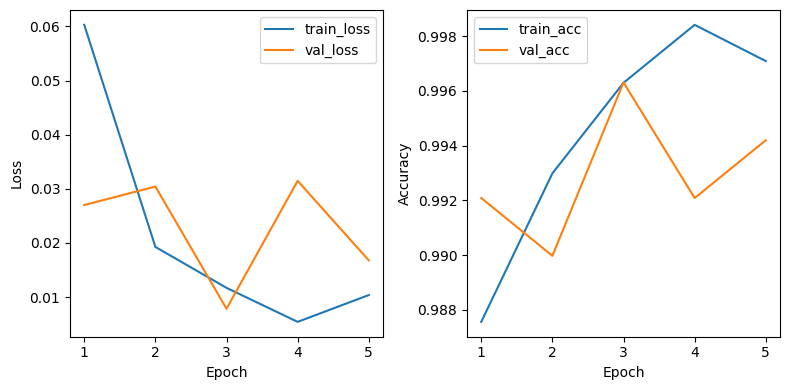

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(hist, save=False, path="training_history.png"):
    epochs = np.arange(1, len(hist["train_loss"]) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    ax1.plot(epochs, hist["train_loss"], label="train_loss")
    ax1.plot(epochs, hist["val_loss"], label="val_loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()

    ax2.plot(epochs, hist["train_acc"], label="train_acc")
    ax2.plot(epochs, hist["val_acc"], label="val_acc")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.legend()

    plt.tight_layout()
    
    if save:
        fig.savefig(path)
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, val_loader, device, save=False, path='confusion_matrix.png'):    
    model.eval()
    hist = {
        "preds" : [],
        "labels": []
    }

    with torch.no_grad():
        for clips, labels in val_loader:
            clips = clips.to(device)
            labels = labels.to(device)

            logits = model(clips)
            preds = logits.argmax(dim=1)

            hist["preds"].append(preds.cpu().numpy())
            hist["labels"].append(labels.cpu().numpy())

    cm = confusion_matrix(np.concatenate(hist["labels"]), np.concatenate(hist["preds"]))

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=ACTION_CLS, yticklabels=ACTION_CLS)
    plt.xlabel("Predicted")
    plt.ylabel("True")

    if save:
        plt.savefig(path, bbox_inches="tight")
    plt.show()

Training with Weighted Cross Entropy Loss

In [ ]:
BASE_DIR = Path("/lebron_clips")

label_counts = []
for i in range(len(ACTION_CLS)):
    dir = BASE_DIR / f"class_{i}"
    count = sum(1 for _ in dir.iterdir())
    label_counts.append(count)

print(label_counts)

[9163, 224, 54, 7]


In [ ]:
class_weights = torch.tensor(label_counts, dtype=torch.float, device=device)
class_weights = 1.0 / class_weights
class_weights /= class_weights.sum()

print(class_weights)

tensor([6.5764e-04, 2.6902e-02, 1.1159e-01, 8.6085e-01], device='cuda:0')


In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
model, hist = model_trainer(train_loader, val_loader, device, criterion=criterion)

device: cuda
Epoch 1:


100%|██████████| 945/945 [38:33<00:00,  2.45s/it]


Epoch 1 — train_loss: 0.317, train_acc: 0.950, val_loss: 0.140, val_acc: 0.972
Epoch 2:


100%|██████████| 945/945 [07:12<00:00,  2.19it/s]


Epoch 2 — train_loss: 0.114, train_acc: 0.985, val_loss: 0.073, val_acc: 0.983
Epoch 3:


100%|██████████| 945/945 [07:14<00:00,  2.18it/s]


Epoch 3 — train_loss: 0.066, train_acc: 0.989, val_loss: 0.071, val_acc: 0.979
Epoch 4:


100%|██████████| 945/945 [07:14<00:00,  2.18it/s]


Epoch 4 — train_loss: 0.045, train_acc: 0.992, val_loss: 0.217, val_acc: 0.972
Epoch 5:


100%|██████████| 945/945 [07:14<00:00,  2.18it/s]


Epoch 5 — train_loss: 0.066, train_acc: 0.988, val_loss: 0.074, val_acc: 0.987


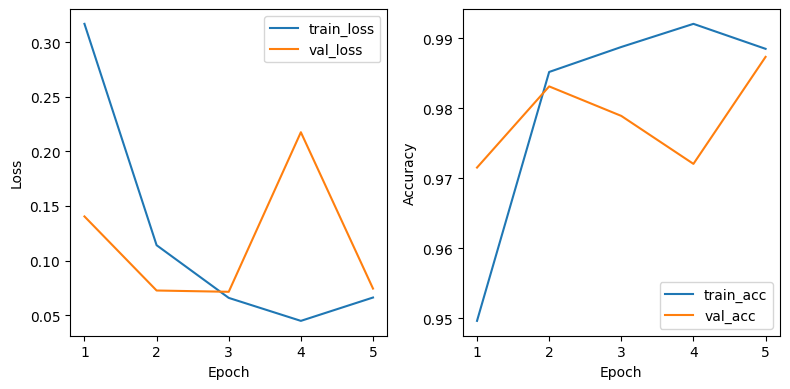

In [ ]:
plot_training_history(hist, save=True)

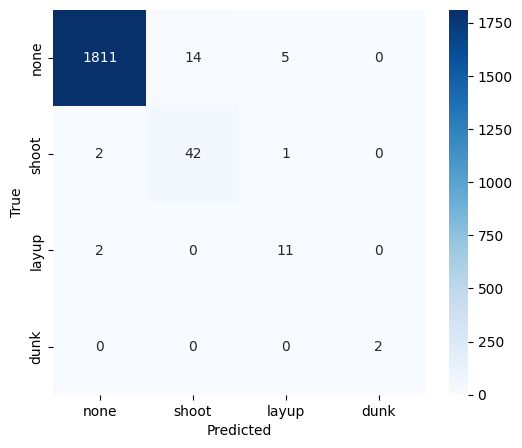

In [ ]:
plot_confusion_matrix(model, val_loader, device, save=True)

In [ ]:
torch.save(model.state_dict(), "action_classifier_wce.pth")

Training with Focal Loss

In [ ]:
from torch.nn import functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction="mean"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, labels):
        ce_loss = F.cross_entropy(logits, labels, reduction="none", weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == "mean":
            return focal_loss.mean()
        elif self.reduction == "sum":
            return focal_loss.sum()
        else:
            return focal_loss

In [ ]:
criterion = FocalLoss(alpha=class_weights)
model, hist = model_trainer(train_loader, val_loader, device, criterion=criterion)

Epoch 1:


100%|██████████| 945/945 [07:18<00:00,  2.15it/s]


Epoch 1 — train_loss: 0.000, train_acc: 0.963, val_loss: 0.000, val_acc: 0.973
Epoch 2:


100%|██████████| 945/945 [07:15<00:00,  2.17it/s]


Epoch 2 — train_loss: 0.000, train_acc: 0.987, val_loss: 0.000, val_acc: 0.975
Epoch 3:


100%|██████████| 945/945 [07:15<00:00,  2.17it/s]


Epoch 3 — train_loss: 0.000, train_acc: 0.992, val_loss: 0.000, val_acc: 0.988
Epoch 4:


100%|██████████| 945/945 [07:14<00:00,  2.17it/s]


Epoch 4 — train_loss: 0.000, train_acc: 0.997, val_loss: 0.000, val_acc: 0.992
Epoch 5:


100%|██████████| 945/945 [07:15<00:00,  2.17it/s]


Epoch 5 — train_loss: 0.000, train_acc: 0.997, val_loss: 0.000, val_acc: 0.989


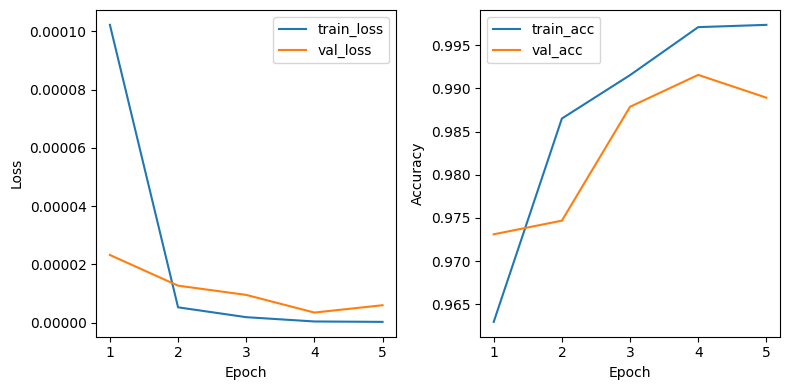

In [ ]:
plot_training_history(hist, save=True)

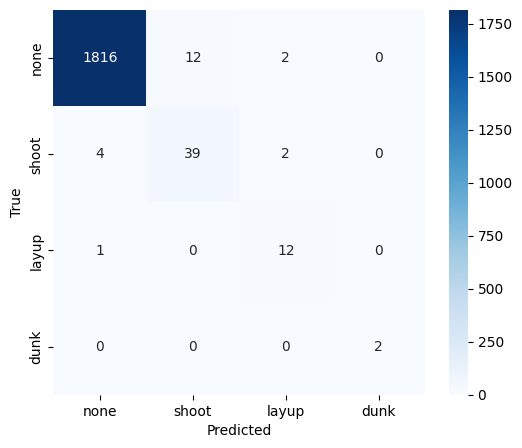

In [ ]:
plot_confusion_matrix(model, val_loader, device, save=True)

In [ ]:
torch.save(model.state_dict(), "action_classifier_f.pth")